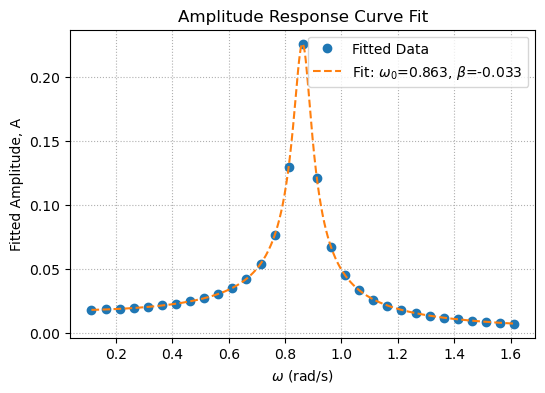

In [221]:
# Re-import necessary libraries since execution state was reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the theoretical amplitude function based on the given equation
def amplitude_model(omega, tau_I, omega_0, B):
    """
    Amplitude response function based on the given equation.

    Parameters:
        omega (array-like): Driving frequency values.
        tau_I (float): Scaling factor τ₀/I.
        omega_0 (float): Natural resonance frequency.
        B (float): Damping coefficient β.

    Returns:
        array-like: Computed amplitude response values.
    """
    denominator = np.sqrt((omega_0**2 - omega**2)**2 + 4 * omega**2 * B**2)
    return (tau_I / denominator)

# Remove NaN values from omega and A_fit_vals
valid_indices = ~np.isnan(omega_vals) & ~np.isnan(A_fit_vals)
if np.any(valid_indices):
    omega_valid = omega_vals[valid_indices]/(2*np.pi)
    A_fit_valid = np.abs(A_fit_vals[valid_indices])  # Ensure amplitudes are positive

    # Initial guess for fitting parameters
    tau_I_guess = np.max(A_fit_valid)  # Rough estimate based on max amplitude
    omega_0_guess = omega_valid[np.argmax(A_fit_valid)]  # Peak frequency estimate
    B_guess = (np.max(omega_valid) - np.min(omega_valid)) / 10  # Rough damping estimate
    initial_guess = [tau_I_guess, omega_0_guess, B_guess]

    # Perform curve fitting
    try:
        popt, pcov = curve_fit(amplitude_model, omega_valid, A_fit_valid, p0=initial_guess)
        tau_I_fit, omega_0_fit, B_fit = popt

        # Generate smooth fit curve
        omega_fit = np.linspace(np.min(omega_valid), np.max(omega_valid), 500)
        A_fit_curve = amplitude_model(omega_fit, tau_I_fit, omega_0_fit, B_fit)

        # Plot results
        plt.figure(figsize=(6, 4))
        plt.plot(omega_valid, A_fit_valid, 'o', label='Fitted Data')
        plt.plot(omega_fit, A_fit_curve, '--', label=f'Fit: $\\omega_0$={omega_0_fit:.3f}, $\\beta$={B_fit:.3f}')
        plt.xlabel(r'$\omega$ (rad/s)')
        plt.ylabel('Fitted Amplitude, A')
        plt.title(r'Amplitude Response Curve Fit')
        plt.grid(True, linestyle=':')
        plt.legend()
        plt.show()

    except RuntimeError:
        print("Curve fitting failed.")
else:
    print("No valid data found for fitting.")


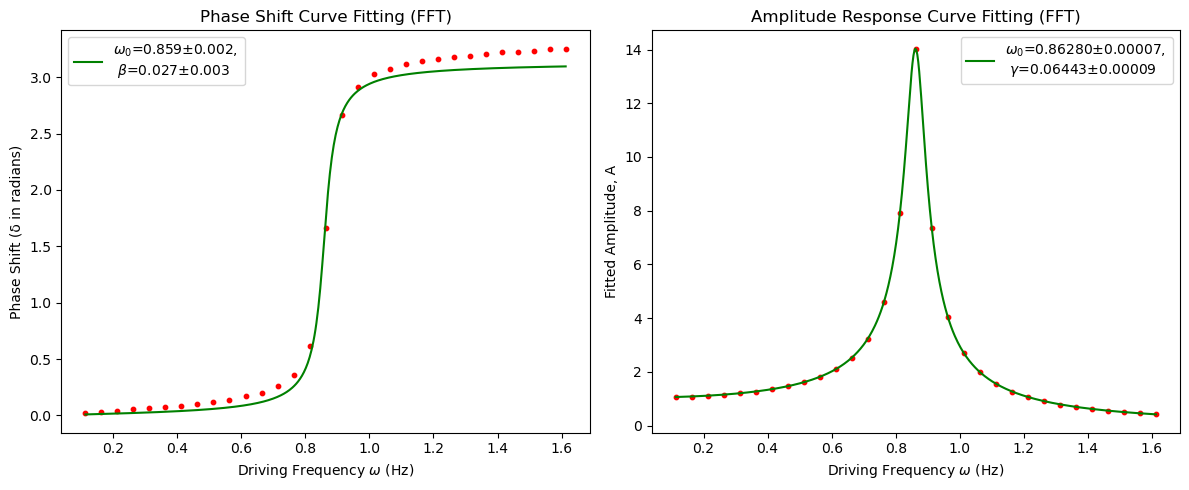

In [243]:
# Re-import necessary libraries since execution state was reset
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.optimize import curve_fit

# Define the phase shift function using cos^-1
def phase_shift_model(omega, omega_0, beta):
    cos_delta = (omega_0**2 - omega**2) / np.sqrt((omega_0**2 - omega**2)**2 + 4 * omega**2 * beta**2)
    return np.arccos(cos_delta)

# Define the Lorentzian function for curve fitting
def lorentzian(omega, A0, omega0, gamma):
    return A0 / np.sqrt((omega0**2 - omega**2)**2 + (gamma * omega)**2)

def analyze_fourier_response(omega_vals, times, amps, drs):
    """
    Performs Fourier analysis on multiple trials of oscillator response data and fits phase shift and amplitude response curves.
    """

    num_trials = len(omega_vals)
    amp_response = np.zeros(num_trials)
    phase_differences = np.zeros(num_trials)

    for i in range(num_trials):
        time = times[i, :]
        amp_signal = amps[i, :]
        dr_signal = drs[i, :]

        # Remove NaNs if present
        valid_indices = ~np.isnan(time) & ~np.isnan(amp_signal) & ~np.isnan(dr_signal)
        time = time[valid_indices]
        amp_signal = amp_signal[valid_indices]
        dr_signal = dr_signal[valid_indices]

        if len(time) == 0:
            print(f"Skipping Trial {i+1} due to missing data.")
            continue

        # Compute sampling properties
        dt = time[1] - time[0]  # Time step (assume uniform spacing)
        N = len(time)  # Number of points

        # Compute Fourier Transforms
        freqs = fftfreq(N, dt)  # Frequency values
        amp_fft = fft(amp_signal)
        dr_fft = fft(dr_signal)
        
        # Find the index closest to the driving frequency
        target_freq = omega_vals[i] / (2 * np.pi)  # Convert omega to Hz
        closest_index = np.argmin(np.abs(freqs - target_freq))

        # Compute amplitude response |A(ω)|
        amp_response[i] = np.abs(amp_fft[closest_index]) / np.abs(dr_fft[closest_index])

        # Compute phase response δ(ω) = φ_V(ω) - φ_r(ω)
        phi_V = np.angle(amp_fft[closest_index])
        phi_r = np.angle(dr_fft[closest_index])
        delta_w = (phi_r - phi_V + np.pi) % (2 * np.pi)  # Normalize to [-π, π]
        phase_differences[i] = delta_w

    # Remove NaNs for fitting
    valid_indices = ~np.isnan(omega_vals) & ~np.isnan(amp_response) & ~np.isnan(phase_differences)
    omega_valid = omega_vals[valid_indices] / (2 * np.pi)  # Convert to Hz
    amp_response_valid = amp_response[valid_indices]
    phase_differences_valid = phase_differences[valid_indices]

    # Fit phase shift model
    initial_guess_phase = [2.0, 0.5]
    popt_phase, pcov_phase = curve_fit(phase_shift_model, omega_valid, phase_differences_valid, p0=initial_guess_phase, bounds=([0, 0], [np.inf, np.inf]))
    omega_0_fit_phase, beta_fit_phase = popt_phase
    omega_0_err_phase, beta_err_phase = np.sqrt(np.diag(pcov_phase))  # Extract errors
    omega_fit_phase = np.linspace(np.min(omega_valid), np.max(omega_valid), 500)
    delta_fit = phase_shift_model(omega_fit_phase, omega_0_fit_phase, beta_fit_phase)

    # Fit amplitude response model
    initial_guess_amp = [np.max(amp_response_valid), omega_valid[np.argmax(amp_response_valid)], (np.max(omega_valid) - np.min(omega_valid)) / 10]
    popt_amp, pcov_amp = curve_fit(lorentzian, omega_valid, amp_response_valid, p0=initial_guess_amp, bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))
    A0_fit_amp, omega0_fit_amp, gamma_fit_amp = popt_amp
    A0_err_amp, omega0_err_amp, gamma_err_amp = np.sqrt(np.diag(pcov_amp))  # Extract errors
    omega_fit_amp = np.linspace(np.min(omega_valid), np.max(omega_valid), 500)
    A_fit_curve = lorentzian(omega_fit_amp, A0_fit_amp, omega0_fit_amp, gamma_fit_amp)

    # Create subplots for FFT results
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Phase shift plot (FFT)
    axs[0].scatter(omega_valid, phase_differences_valid, color='red', s=10)
    axs[0].plot(omega_fit_phase, delta_fit, linestyle='-', color='green', 
                label=f'$\\omega_0$={omega_0_fit_phase:.3f}±{omega_0_err_phase:.3f}, \n $\\beta$={beta_fit_phase:.3f}±{beta_err_phase:.3f}')
    axs[0].set_xlabel(r'Driving Frequency $\omega$ (Hz)')
    axs[0].set_ylabel('Phase Shift (δ in radians)')
    axs[0].set_title('Phase Shift Curve Fitting (FFT)')
    axs[0].legend()
    axs[0].grid(False)

    # Amplitude response plot (FFT)
    axs[1].scatter(omega_valid, amp_response_valid, color='red', s=10)
    axs[1].plot(omega_fit_amp, A_fit_curve, linestyle='-', color='green', 
                label=f'$\\omega_0$={omega0_fit_amp:.5f}±{omega0_err_amp:.5f}, \n $\\gamma$={gamma_fit_amp:.5f}±{gamma_err_amp:.5f}')
    axs[1].set_xlabel(r'Driving Frequency $\omega$ (Hz)')
    axs[1].set_ylabel('Fitted Amplitude, A')
    axs[1].set_title(r'Amplitude Response Curve Fitting (FFT)')
    axs[1].legend()
    axs[1].grid(False)

    # Show plot
    plt.tight_layout()
    plt.show()

    return amp_response, phase_differences

# Example usage (replace with actual omega, times, amps, drs data)
amp_response_fft, phase_differences_fft = analyze_fourier_response(omega_vals, times, amps, drs)

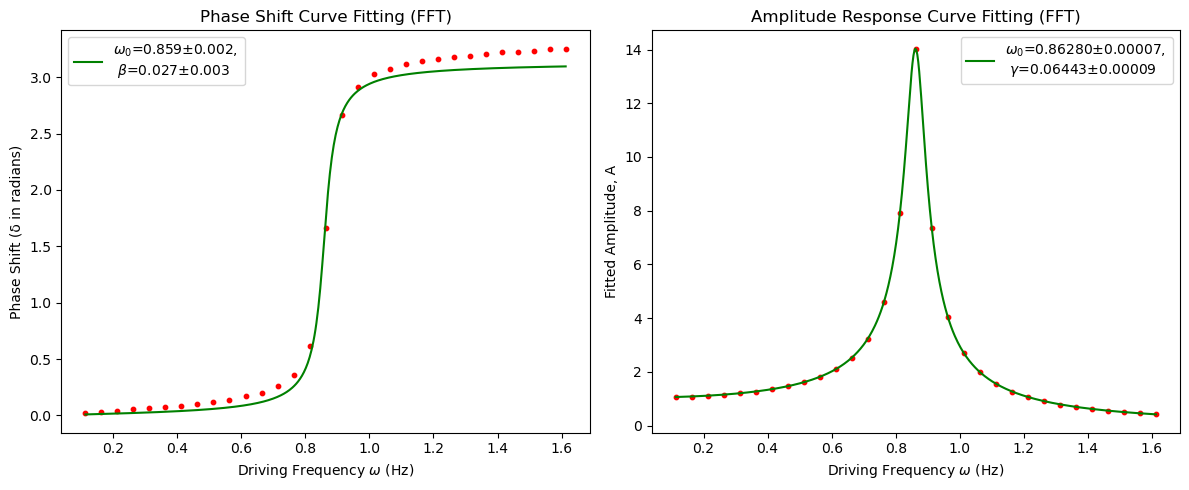

In [243]:
# Re-import necessary libraries since execution state was reset
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.optimize import curve_fit

# Define the phase shift function using cos^-1
def phase_shift_model(omega, omega_0, beta):
    cos_delta = (omega_0**2 - omega**2) / np.sqrt((omega_0**2 - omega**2)**2 + 4 * omega**2 * beta**2)
    return np.arccos(cos_delta)

# Define the Lorentzian function for curve fitting
def lorentzian(omega, A0, omega0, gamma):
    return A0 / np.sqrt((omega0**2 - omega**2)**2 + (gamma * omega)**2)

def analyze_fourier_response(omega_vals, times, amps, drs):
    """
    Performs Fourier analysis on multiple trials of oscillator response data and fits phase shift and amplitude response curves.
    """

    num_trials = len(omega_vals)
    amp_response = np.zeros(num_trials)
    phase_differences = np.zeros(num_trials)

    for i in range(num_trials):
        time = times[i, :]
        amp_signal = amps[i, :]
        dr_signal = drs[i, :]

        # Remove NaNs if present
        valid_indices = ~np.isnan(time) & ~np.isnan(amp_signal) & ~np.isnan(dr_signal)
        time = time[valid_indices]
        amp_signal = amp_signal[valid_indices]
        dr_signal = dr_signal[valid_indices]

        if len(time) == 0:
            print(f"Skipping Trial {i+1} due to missing data.")
            continue

        # Compute sampling properties
        dt = time[1] - time[0]  # Time step (assume uniform spacing)
        N = len(time)  # Number of points

        # Compute Fourier Transforms
        freqs = fftfreq(N, dt)  # Frequency values
        amp_fft = fft(amp_signal)
        dr_fft = fft(dr_signal)
        
        # Find the index closest to the driving frequency
        target_freq = omega_vals[i] / (2 * np.pi)  # Convert omega to Hz
        closest_index = np.argmin(np.abs(freqs - target_freq))

        # Compute amplitude response |A(ω)|
        amp_response[i] = np.abs(amp_fft[closest_index]) / np.abs(dr_fft[closest_index])

        # Compute phase response δ(ω) = φ_V(ω) - φ_r(ω)
        phi_V = np.angle(amp_fft[closest_index])
        phi_r = np.angle(dr_fft[closest_index])
        delta_w = (phi_r - phi_V + np.pi) % (2 * np.pi)  # Normalize to [-π, π]
        phase_differences[i] = delta_w

    # Remove NaNs for fitting
    valid_indices = ~np.isnan(omega_vals) & ~np.isnan(amp_response) & ~np.isnan(phase_differences)
    omega_valid = omega_vals[valid_indices] / (2 * np.pi)  # Convert to Hz
    amp_response_valid = amp_response[valid_indices]
    phase_differences_valid = phase_differences[valid_indices]

    # Fit phase shift model
    initial_guess_phase = [2.0, 0.5]
    popt_phase, pcov_phase = curve_fit(phase_shift_model, omega_valid, phase_differences_valid, p0=initial_guess_phase, bounds=([0, 0], [np.inf, np.inf]))
    omega_0_fit_phase, beta_fit_phase = popt_phase
    omega_0_err_phase, beta_err_phase = np.sqrt(np.diag(pcov_phase))  # Extract errors
    omega_fit_phase = np.linspace(np.min(omega_valid), np.max(omega_valid), 500)
    delta_fit = phase_shift_model(omega_fit_phase, omega_0_fit_phase, beta_fit_phase)

    # Fit amplitude response model
    initial_guess_amp = [np.max(amp_response_valid), omega_valid[np.argmax(amp_response_valid)], (np.max(omega_valid) - np.min(omega_valid)) / 10]
    popt_amp, pcov_amp = curve_fit(lorentzian, omega_valid, amp_response_valid, p0=initial_guess_amp, bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))
    A0_fit_amp, omega0_fit_amp, gamma_fit_amp = popt_amp
    A0_err_amp, omega0_err_amp, gamma_err_amp = np.sqrt(np.diag(pcov_amp))  # Extract errors
    omega_fit_amp = np.linspace(np.min(omega_valid), np.max(omega_valid), 500)
    A_fit_curve = lorentzian(omega_fit_amp, A0_fit_amp, omega0_fit_amp, gamma_fit_amp)

    # Create subplots for FFT results
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Phase shift plot (FFT)
    axs[0].scatter(omega_valid, phase_differences_valid, color='red', s=10)
    axs[0].plot(omega_fit_phase, delta_fit, linestyle='-', color='green', 
                label=f'$\\omega_0$={omega_0_fit_phase:.3f}±{omega_0_err_phase:.3f}, \n $\\beta$={beta_fit_phase:.3f}±{beta_err_phase:.3f}')
    axs[0].set_xlabel(r'Driving Frequency $\omega$ (Hz)')
    axs[0].set_ylabel('Phase Shift (δ in radians)')
    axs[0].set_title('Phase Shift Curve Fitting (FFT)')
    axs[0].legend()
    axs[0].grid(False)

    # Amplitude response plot (FFT)
    axs[1].scatter(omega_valid, amp_response_valid, color='red', s=10)
    axs[1].plot(omega_fit_amp, A_fit_curve, linestyle='-', color='green', 
                label=f'$\\omega_0$={omega0_fit_amp:.5f}±{omega0_err_amp:.5f}, \n $\\gamma$={gamma_fit_amp:.5f}±{gamma_err_amp:.5f}')
    axs[1].set_xlabel(r'Driving Frequency $\omega$ (Hz)')
    axs[1].set_ylabel('Fitted Amplitude, A')
    axs[1].set_title(r'Amplitude Response Curve Fitting (FFT)')
    axs[1].legend()
    axs[1].grid(False)

    # Show plot
    plt.tight_layout()
    plt.show()

    return amp_response, phase_differences

# Example usage (replace with actual omega, times, amps, drs data)
amp_response_fft, phase_differences_fft = analyze_fourier_response(omega_vals, times, amps, drs)